# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-401s01et
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-401s01et
     |████████████████████████████████| 645kB 5.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=64354 sha256=f26ec585b65bca4fa6523249da87fc8adaa8e9b4ea3f57501b6618be1d54699e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pktkocah/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.8.1+cu101'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12382, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 12382 (delta 156), reused 268 (delta 145), pack-reused 12093
Receiving objects: 100% (12382/12382), 4.91 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (8993/8993), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 153kB 6.9MB/s 
     |████████████████████████████████| 133kB 7.1MB/s 
     |████████████████████████████████| 112kB 7.6MB/s 
     |████████████████████████████████| 747kB 7.6MB/s 
     |████████████████████████████████| 727kB 12.8MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=b37a938ae0678c9e3b1680f7d067754054d09842b60d8e0d45c766c57f6fdea2
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47e

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("steel_dataset_train", {}, "./train/trainval.json", "./train")
register_coco_instances("steel_dataset_val", {}, "./valid/valid.json", "./valid")
register_coco_instances("steel_dataset_test", {}, "./test/test.json", "./test")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [06/14 10:43:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 10:43:09 d2.data.datasets.coco]: Loaded 262 images in COCO format from ./train/trainval.json


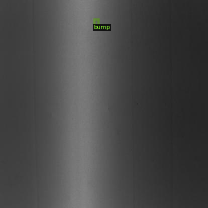

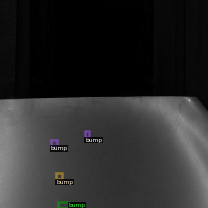

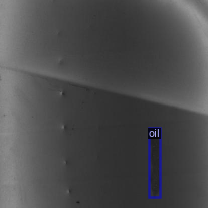

In [9]:
my_dataset_train_metadata = MetadataCatalog.get("steel_dataset_train")
dataset_dicts = DatasetCatalog.get("steel_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the steel dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("steel_dataset_train",)
cfg.DATASETS.TEST = ("steel_dataset_val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml" ) # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =128  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)
cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 10:43:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_298dad.pkl: 212MB [00:18, 11.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (12, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[06/14 10:44:18 d2.engine.train_loop]: Starting training from iteration 0
[06/14 10:44:52 d2.utils.events]:  eta: 0:27:15  iter: 19  total_loss: 1.475  loss_cls: 1.208  loss_box_reg: 0.1115  loss_rpn_cls: 0.07885  loss_rpn_loc: 0.007607  time: 1.6777  data_time: 0.0149  lr: 4.9952e-05  max_mem: 2478M
[06/14 10:45:26 d2.utils.events]:  eta: 0:26:59  iter: 39  total_loss: 0.4073  loss_cls: 0.2277  loss_box_reg: 0.06483  loss_rpn_cls: 0.06886  loss_rpn_loc: 0.006399  time: 1.6837  data_time: 0.0098  lr: 9.9902e-05  max_mem: 2478M
[06/14 10:45:59 d2.utils.events]:  eta: 0:26:15  iter: 59  total_loss: 0.4075  loss_cls: 0.1851  loss_box_reg: 0.1515  loss_rpn_cls: 0.05743  loss_rpn_loc: 0.008161  time: 1.6682  data_time: 0.0095  lr: 0.00014985  max_mem: 2478M
[06/14 10:46:32 d2.utils.events]:  eta: 0:25:42  iter: 79  total_loss: 0.3084  loss_cls: 0.1393  loss_box_reg: 0.1298  loss_rpn_cls: 0.01865  loss_rpn_loc: 0.006425  time: 1.6675  data_time: 0.0073  lr: 0.0001998  max_mem: 2478M
[06/14 1

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [25]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("steel_dataset_test", )
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("steel_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "steel_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/14 11:29:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 11:29:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 11:29:26 d2.data.datasets.coco]: Loaded 37 images in COCO format from ./test/test.json
[06/14 11:29:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 11:29:26 d2.data.common]: Serializing 37 elements to byte tensors and concatenating them all ...
[06/14 11:29:26 d2.data.common]: Serialized dataset takes 0.01 MiB
[06/14 11:29:26 d2.evaluation.evaluator]: Start inference on 37 batches
[06/14 11:29:38 d2.evaluation.evaluator]: Inference done 11/37. Dataloading: 0.0023 s / iter. Inference: 1.0327 s / iter. Eval: 0.0003 s / iter. Total: 1.0354 s / iter. ETA=0:0

OrderedDict([('bbox',
              {'AP': 37.01786249748584,
               'AP-bump': 14.59678110058224,
               'AP-oil': 59.43894389438944,
               'AP-steel': nan,
               'AP50': 66.33743245431066,
               'AP75': 34.077479112312616,
               'APl': nan,
               'APm': 82.21122112211219,
               'APs': 25.56599934937749})])

Then, we randomly select several samples to visualize the prediction results.

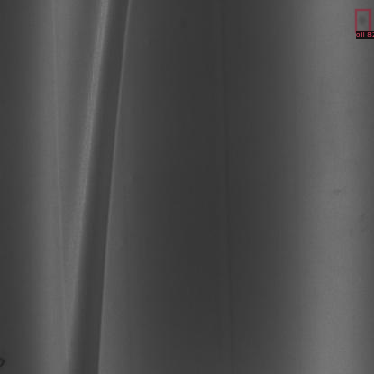

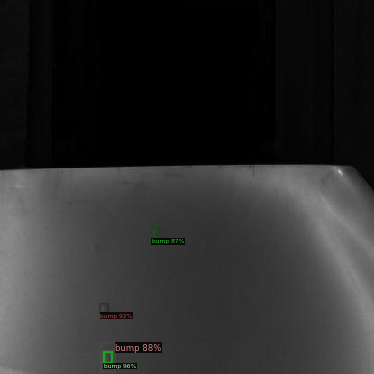

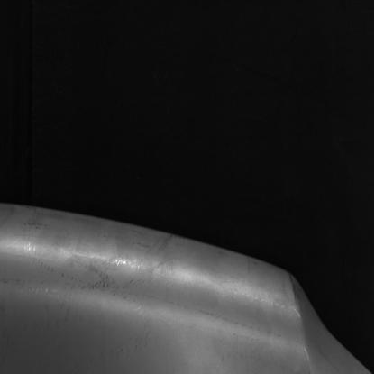

In [19]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, 
                   scale=0.9, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

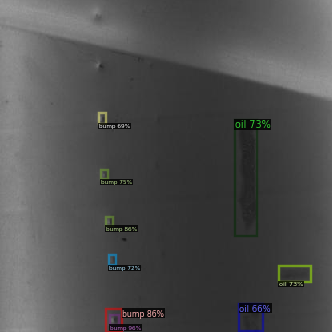

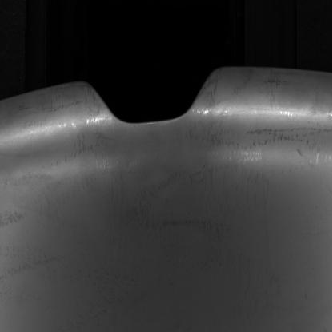

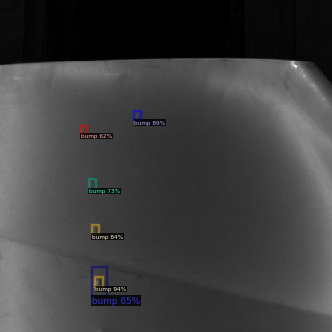

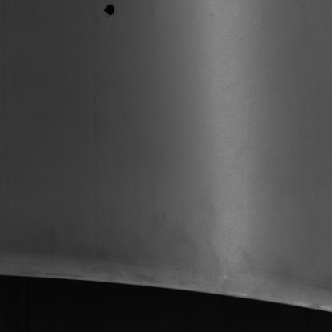

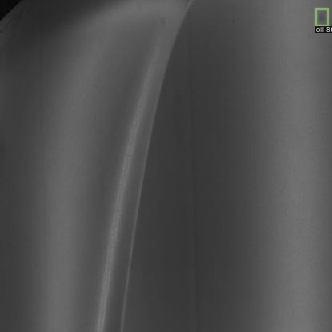

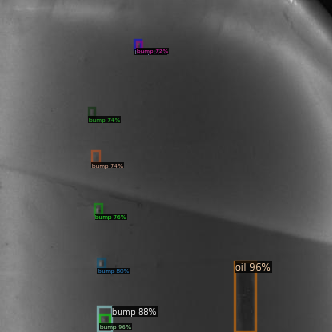

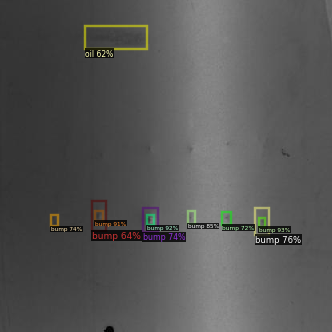

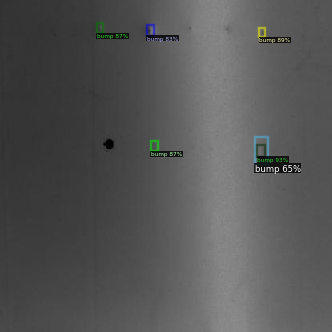

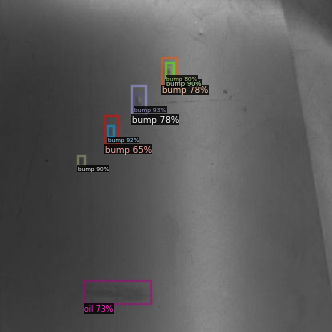

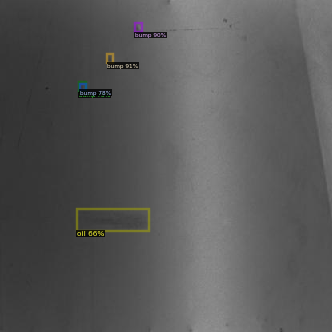

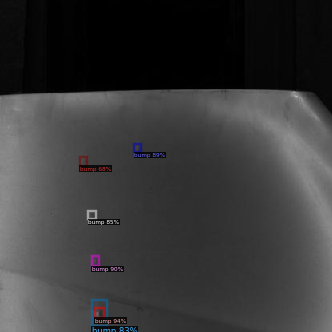

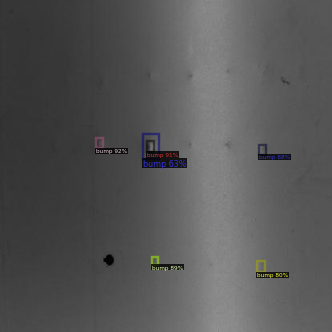

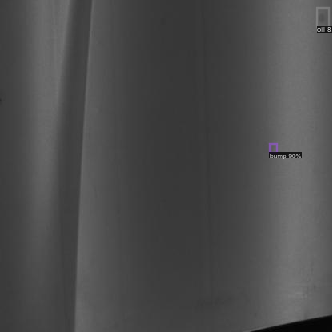

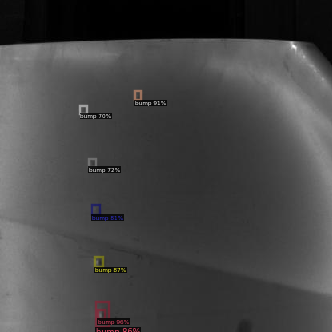

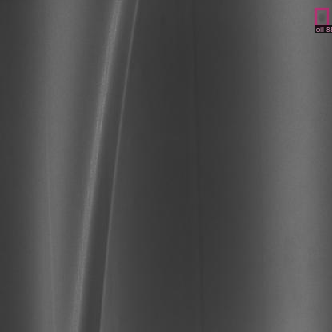

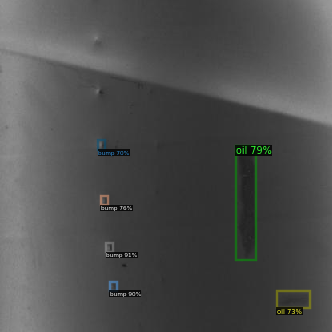

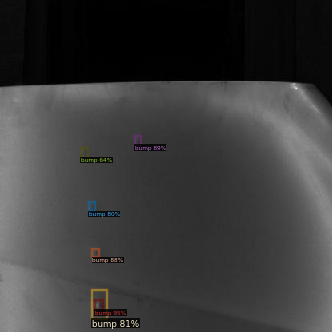

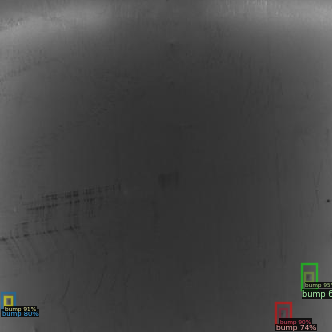

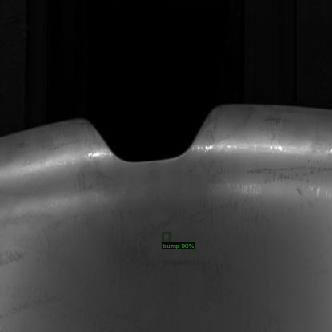

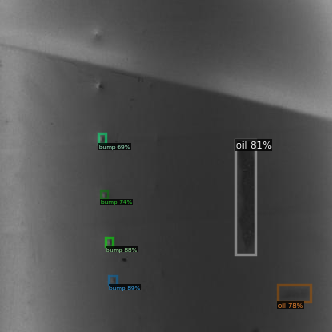

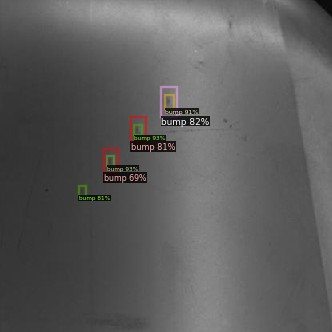

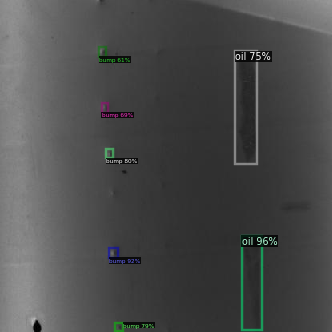

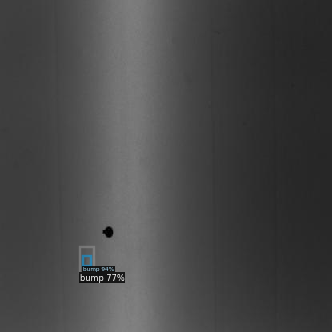

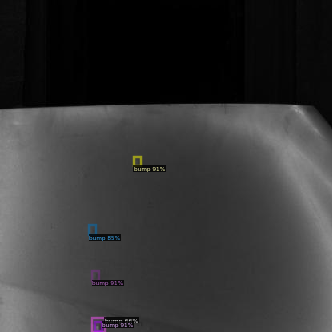

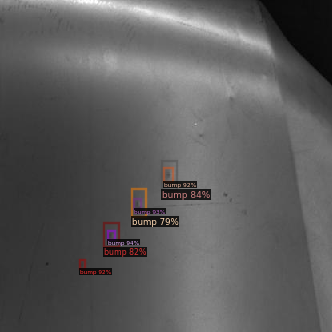

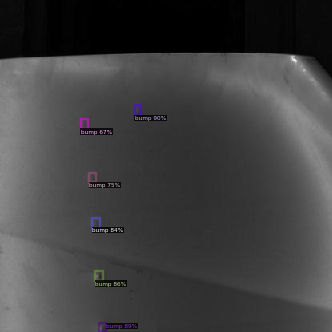

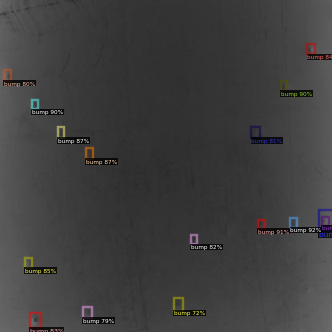

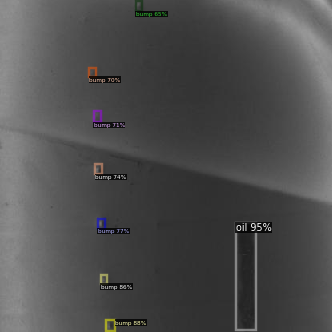

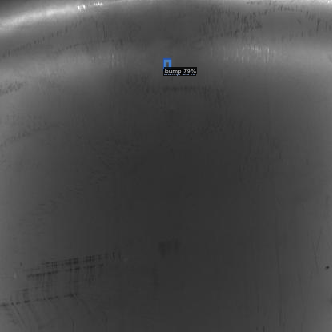

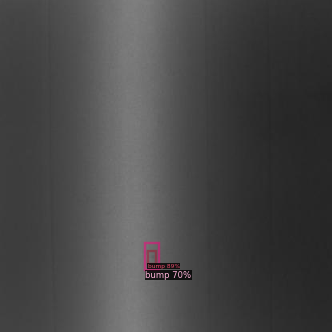

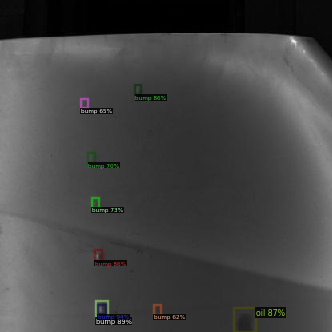

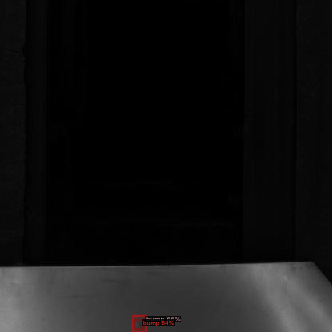

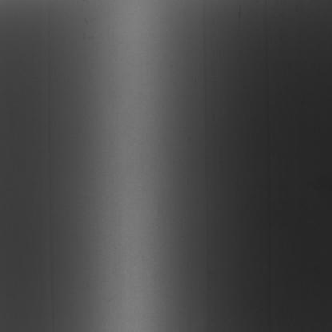

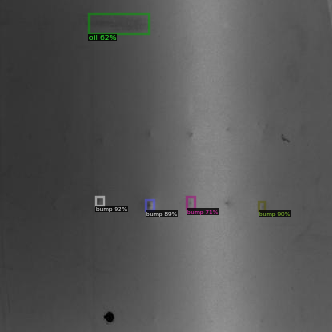

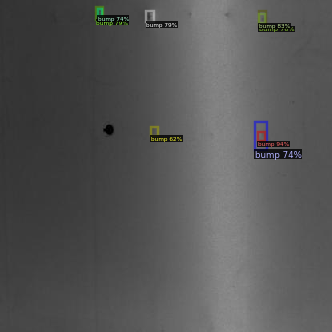

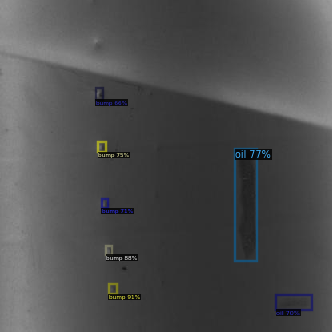

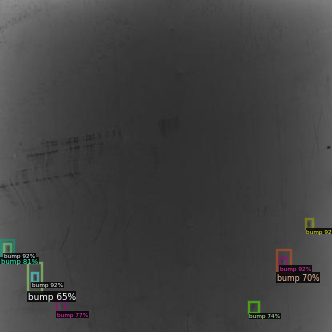

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("steel_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("steel_dataset_test")

from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('./test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
my_dataset_train_metadata

Metadata(evaluator_type='coco', image_root='./train', json_file='./train/trainval.json', name='steel_dataset_train', thing_classes=['steel', 'bump', 'oil'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

## Benchmark inference speed

In [22]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):1.04,fps:0.96
